## Team Members:
## Mariz Youssef Abdelmessih Gerges,  ID: 2001122
## Carol Maged Victor Amin,  ID: 2001072
## Jasmine Mamdouh Mostafa Ibrahim, ID: 2000016


# Phase 2

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, roc_curve,accuracy_score,precision_score,recall_score
,make_scorer,f1_score,auc,precision_recall_curve,precision_recall_fscore_support)
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
from sklearn.svm import SVC


In [100]:
# Load dataset
data = pd.read_csv('data.csv')

In [101]:
# Based on the correlation matrix results
# Feature-target split, drop useless features (have low values of correlation)
X = data.drop(['result', 'Unnamed: 0','location','symptom5','symptom6'], axis=1)
y = data['result']

# Split into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Total number of samples
total_samples = len(data)

# Calculate sizes and percentages
train_size = len(X_train) / total_samples * 100
val_size = len(X_val) / total_samples * 100
test_size = len(X_test) / total_samples * 100

# Print the data sizes and percentages
print(f"Training set size: {len(X_train)} samples ({train_size:.2f}%)")
print(f"Validation set size: {len(X_val)} samples ({val_size:.2f}%)")
print(f"Testing set size: {len(X_test)} samples ({test_size:.2f}%)")


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



Training set size: 604 samples (69.99%)
Validation set size: 129 samples (14.95%)
Testing set size: 130 samples (15.06%)


In [102]:
# Justification for Using SMOTE
# 1-Avoids Bias Towards the Majority Class
# 2-Improved Evaluation Metrics
# 3-Balanced Dataset for Better Generalization
RANDOM_STATE=42
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Decision Tree Classifier

In [103]:
# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [104]:
# Define hyperparameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# Perform GridSearchCV with StratifiedKFold
grid_search_dt = GridSearchCV(
    dt_model,
    param_grid_dt,
    scoring='f1',  # Optimize for F1-score
    refit='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    verbose=1
)

# Fit GridSearchCV to the resampled training data
grid_search_dt.fit(X_train_resampled, y_train_resampled)

# Extract the best model
best_dt_model = grid_search_dt.best_estimator_
print(f"Best Parameters for Decision Tree: {grid_search_dt.best_params_}")

# Train the Decision Tree on the training data
best_dt_model.fit(X_train, y_train)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters for Decision Tree: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

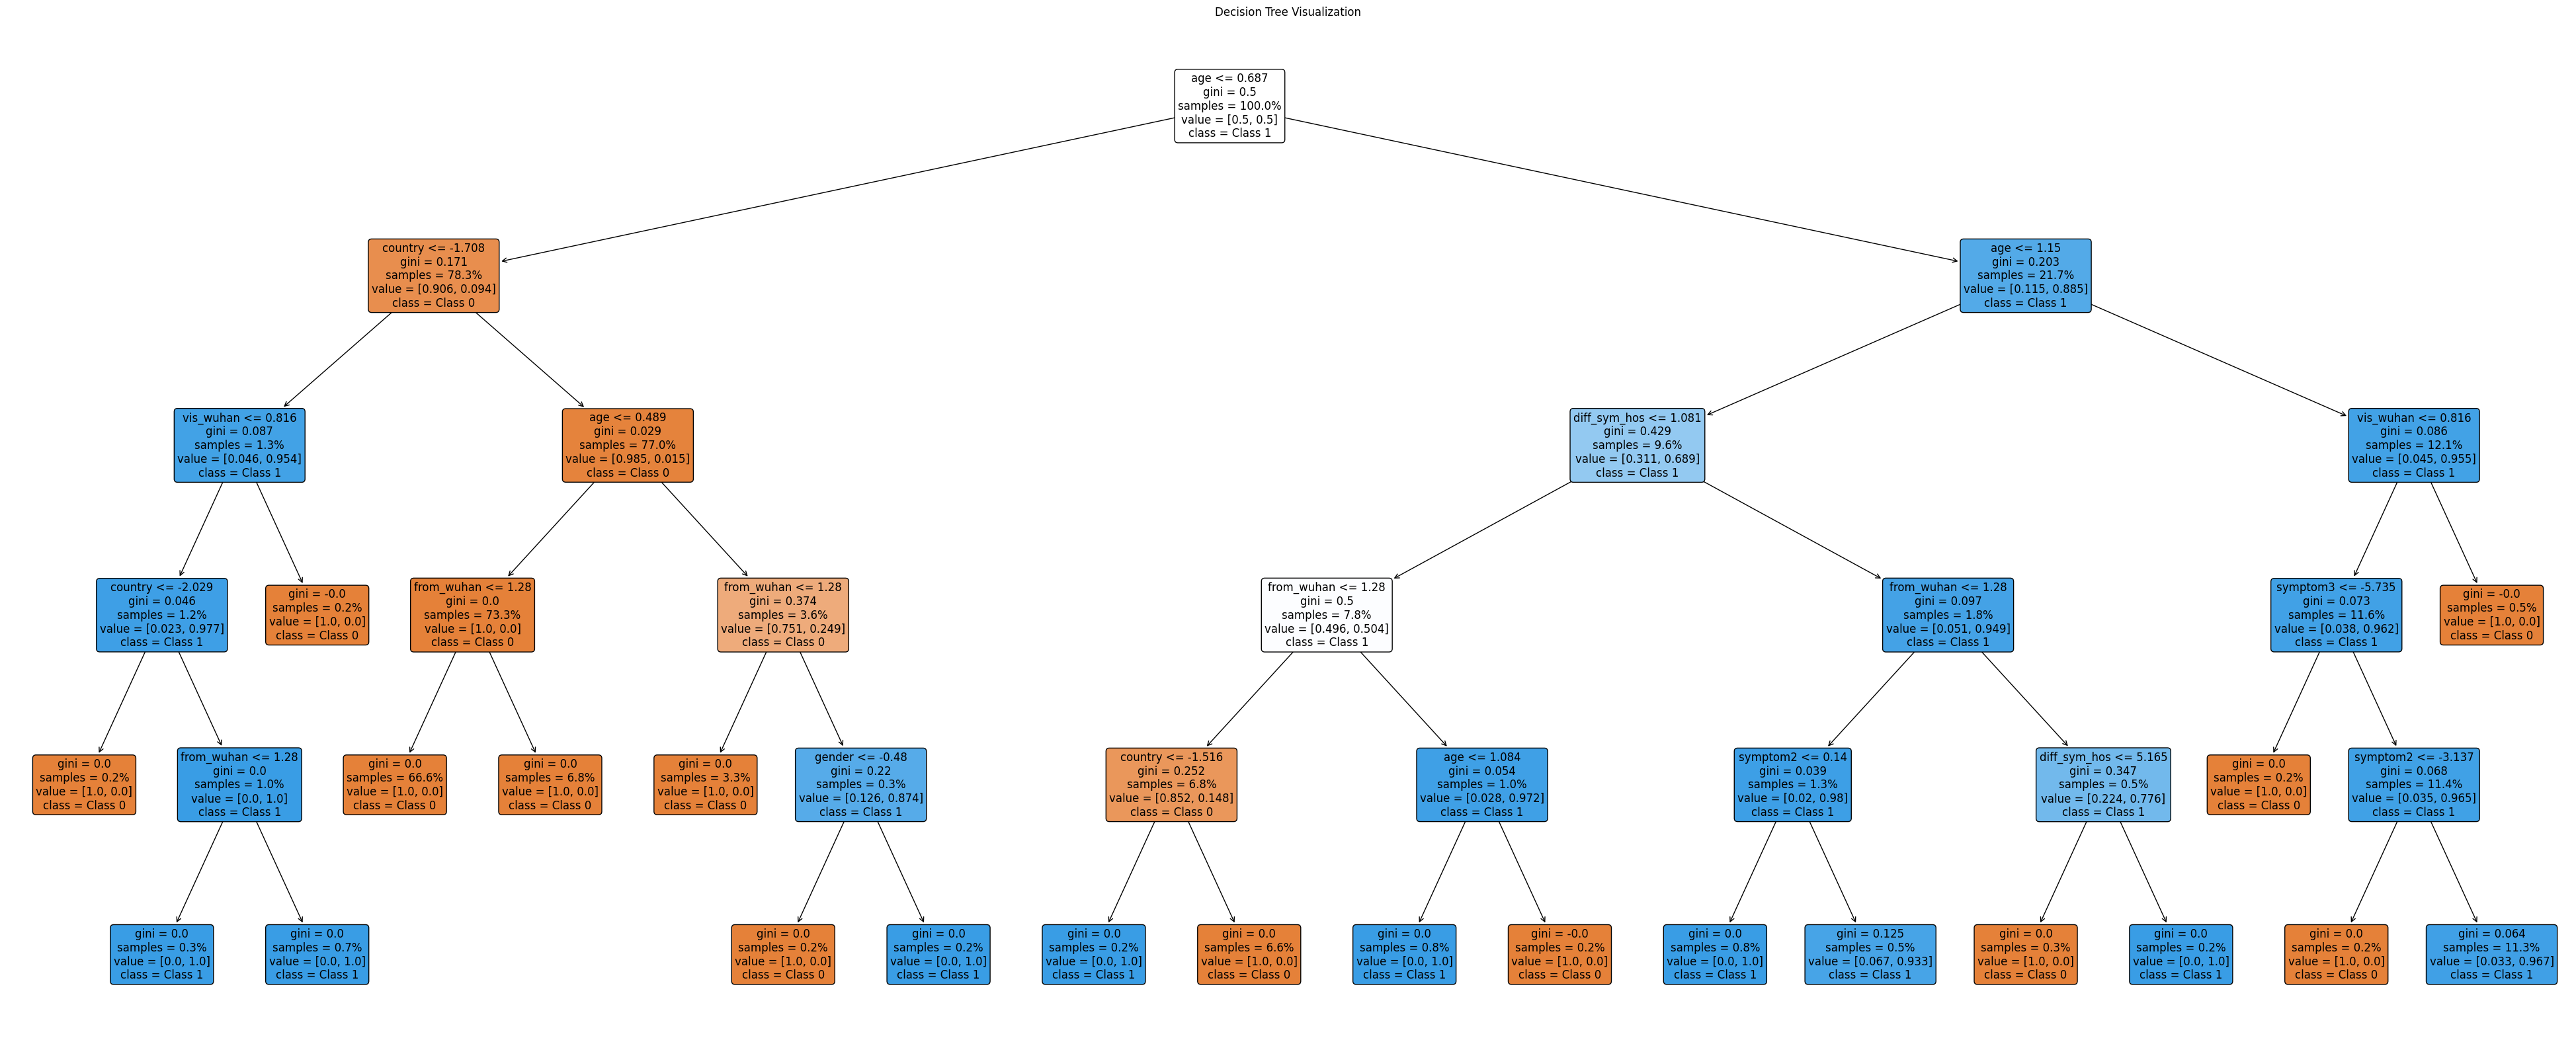

In [105]:
# Visualize the Decision Tree
"""
dot_data = StringIO()
export_graphviz(best_dt_model, out_file = dot_data, rounded = True, filled = True, special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("dtree.png")
Image(graph.create_png())
"""

# Convert X_train to a DataFrame 
X_train_df = pd.DataFrame(X_train, columns=['country', 'gender', 'age', 'vis_wuhan',
       'from_wuhan', 'symptom1', 'symptom2', 'symptom3', 'symptom4', 'diff_sym_hos',])  

# Plot the decision tree
plt.figure(figsize=(50, 20))
plot_tree(best_dt_model,
          feature_names=X_train_df.columns,  # Use DataFrame column names
          class_names=['Class 0', 'Class 1'],  
          filled=True,  # Color nodes based on class
          rounded=True,  # Round the corners of the nodes
          proportion=True,  # Proportions for the samples
          fontsize=12)  # Font size for text in the tree
plt.title('Decision Tree Visualization')
plt.show()

In [106]:
# Evaluate on validation data
y_val_proba_dt = best_dt_model.predict_proba(X_val)[:, 1]  # Probabilities for ROC and threshold tuning

# Tune Threshold for Optimal Precision-Recall Balance
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba_dt)
optimal_idx = np.argmax(2 * (precisions * recalls) / (precisions + recalls))  # Maximize F1-Score
optimal_threshold_dt = thresholds[optimal_idx]

# Apply the new threshold
y_val_pred_threshold_dt = (y_val_proba_dt >= optimal_threshold_dt).astype(int)

# Metrics
print("\nDecision Tree - Validation Set Metrics:")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_threshold_dt))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_threshold_dt))

roc_auc_dt = roc_auc_score(y_val, y_val_proba_dt)
print(f"ROC-AUC Score: {roc_auc_dt:.4f}")

print(f"Optimal Threshold: {optimal_threshold_dt:.4f}")



Decision Tree - Validation Set Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       113
           1       0.79      0.94      0.86        16

    accuracy                           0.96       129
   macro avg       0.89      0.95      0.92       129
weighted avg       0.97      0.96      0.96       129

Confusion Matrix:
[[109   4]
 [  1  15]]
ROC-AUC Score: 0.9450
Optimal Threshold: 0.9329



Decision Tree - Test Set Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       114
           1       0.72      0.81      0.76        16

    accuracy                           0.94       130
   macro avg       0.85      0.88      0.86       130
weighted avg       0.94      0.94      0.94       130

Confusion Matrix:
[[109   5]
 [  3  13]]
ROC-AUC Score: 0.8797
Optimal Threshold: 0.9671


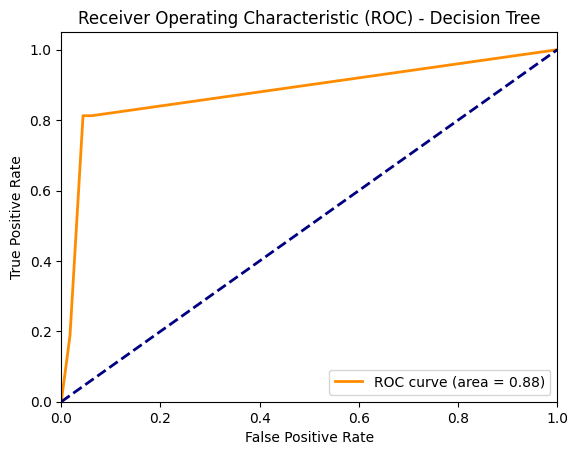

In [107]:
# Evaluate on test data
y_test_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC and threshold tuning

# Tune Threshold for Optimal Precision-Recall Balance
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba_dt)
optimal_idx = np.argmax(2 * (precisions * recalls) / (precisions + recalls))  # Maximize F1-Score
optimal_threshold_dt = thresholds[optimal_idx]

# Apply the new threshold
y_test_pred_threshold_dt = (y_test_proba_dt >= optimal_threshold_dt).astype(int)

# Metrics for Test Set
print("\nDecision Tree - Test Set Metrics:")
print("Classification Report:")
print(classification_report(y_test, y_test_pred_threshold_dt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_threshold_dt))

roc_auc_test_dt = roc_auc_score(y_test, y_test_proba_dt)
print(f"ROC-AUC Score: {roc_auc_test_dt:.4f}")

print(f"Optimal Threshold: {optimal_threshold_dt:.4f}")

# Plot ROC Curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_test_proba_dt)
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Decision Tree')
plt.legend(loc="lower right")
plt.show()

## Support Vector Machines

In [108]:
# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['rbf']  # Using RBF kernel
}

# Initialize SVM model
svm_clf = SVC(probability=True, random_state=RANDOM_STATE)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=svm_clf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Metric to optimize
    verbose=2,  # Display progress
    n_jobs=-1  # Use all processors
)

# Fit on resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and score
print("\nBest Parameters:", grid_search.best_params_)
print("Best ROC-AUC Score during Grid Search:", grid_search.best_score_)

# Use the best model for predictions
best_svm_clf = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best ROC-AUC Score during Grid Search: 0.99393700520436


In [109]:
# Predict on validation set
y_val_proba_svm = best_svm_clf.predict_proba(X_val)[:, 1]  # Probabilities for ROC/AUC
y_val_pred_svm = best_svm_clf.predict(X_val)

# Metrics for Validation Data
print("\nSupport Vector Machines (SVM) - Validation Set Metrics:")
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred_svm))

print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, y_val_pred_svm))

roc_auc_val = roc_auc_score(y_val, y_val_proba_svm)
print(f"ROC-AUC Score (Validation): {roc_auc_val:.4f}")


Support Vector Machines (SVM) - Validation Set Metrics:
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       113
           1       0.79      0.94      0.86        16

    accuracy                           0.96       129
   macro avg       0.89      0.95      0.92       129
weighted avg       0.97      0.96      0.96       129

Confusion Matrix (Validation):
[[109   4]
 [  1  15]]
ROC-AUC Score (Validation): 0.9834



Support Vector Machines (SVM) - Test Set Metrics:
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       114
           1       0.79      0.94      0.86        16

    accuracy                           0.96       130
   macro avg       0.89      0.95      0.92       130
weighted avg       0.97      0.96      0.96       130

Confusion Matrix (Test):
[[110   4]
 [  1  15]]
ROC-AUC Score (Test): 0.9874
Precision (Validation): 0.7895
Recall (Validation): 0.9375
F1-Score (Validation): 0.8571
Precision (Test): 0.7895
Recall (Test): 0.9375
F1-Score (Test): 0.8571


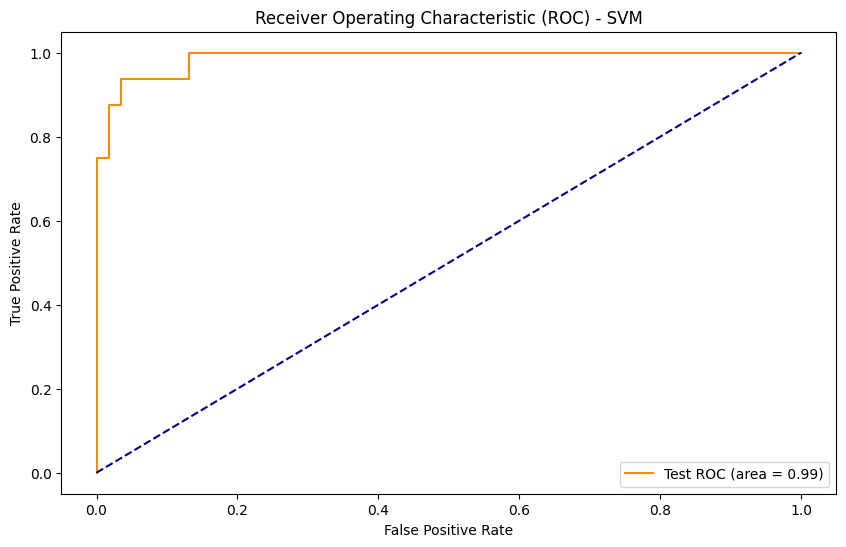

In [110]:
# Predict on test set
y_test_proba = best_svm_clf.predict_proba(X_test)[:, 1]  # Probabilities for ROC/AUC
y_test_pred = best_svm_clf.predict(X_test)

# Metrics for Test Data
print("\nSupport Vector Machines (SVM) - Test Set Metrics:")
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

roc_auc_test_svm = roc_auc_score(y_test, y_test_proba)
print(f"ROC-AUC Score (Test): {roc_auc_test_svm:.4f}")

# Precision, Recall, F1-score for Validation
precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(
    y_val, y_val_pred_svm, average="binary"
)
print(f"Precision (Validation): {precision_val:.4f}")
print(f"Recall (Validation): {recall_val:.4f}")
print(f"F1-Score (Validation): {f1_val:.4f}")

# Precision, Recall, F1-score for Test
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average="binary"
)
print(f"Precision (Test): {precision_test:.4f}")
print(f"Recall (Test): {recall_test:.4f}")
print(f"F1-Score (Test): {f1_test:.4f}")

fpr_test_svm, tpr_test_svm, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
#plt.plot(fpr_val, tpr_val, label=f"Validation ROC (area = {roc_auc_val:.2f})", color="blue")
plt.plot(fpr_test_svm, tpr_test_svm, label=f"Test ROC (area = {roc_auc_test_svm:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) - SVM")
plt.legend(loc="lower right")
plt.show()

## Comparison between the two classifiers

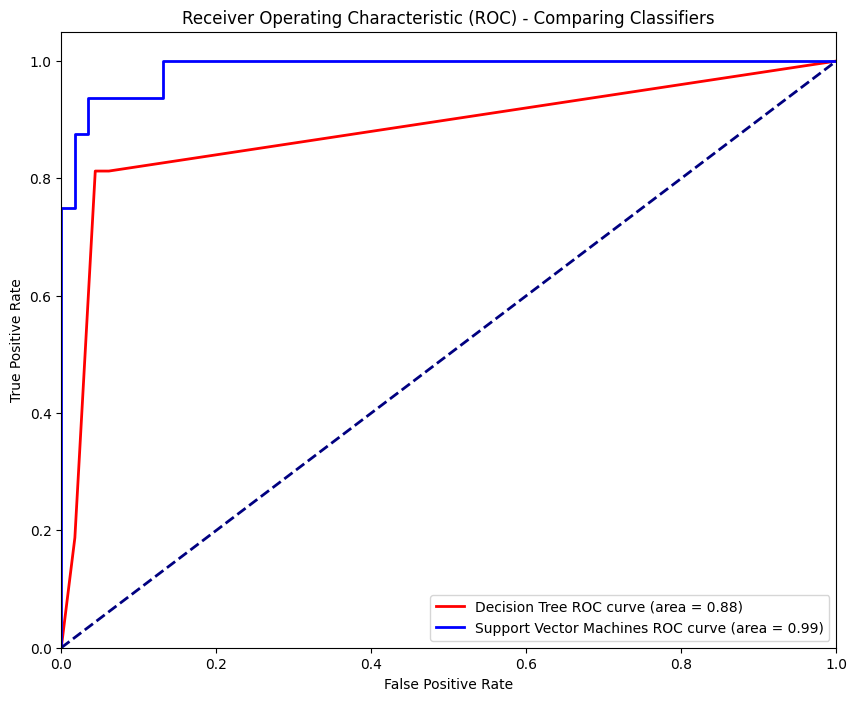

In [111]:
# Plot ROC Curves for multiple classifiers on the same plot
plt.figure(figsize=(10, 8))

# Decision tree ROC curve
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label=f'Decision Tree ROC curve (area = {roc_auc_test_dt:.2f})')

# Support Vector Machines ROC curve
plt.plot(fpr_test_svm, tpr_test_svm, color='blue', lw=2, label=f'Support Vector Machines ROC curve (area = {roc_auc_test_svm:.2f})')

# Adding a diagonal line representing random guesses (no discrimination)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Configure the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Comparing Classifiers')

# Add a legend
plt.legend(loc="lower right")

# Show the plot
plt.show()
